In [3]:
! pip3 install py4j==0.10.7
#! pip3 install numpy==1.13.3 --user
! pip3 install xgboost --user
! pip3 install pdpbox --user
! pip3 install comet_ml --user

     |████████████████████████████████| 174kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 204kB 26.7MB/s eta 0:00:01
     |████████████████████████████████| 409kB 22.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 17.6MB/s eta 0:00:01
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-cp37-none-any.whl size=19192 sha256=5ca244a602f3b8fbf63936fa4573ccefba98ea957c495313d92b671d59f677d3
  Stored in directory: /Users/krishi/Library/Caches/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=610607b7537494941255a805ead10225cdf7961a8b16084ecf7279c2c3784dd9
  Stored in directory: /Users/krishi/Library/Caches/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built nvidia-ml-py3 configobj
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Con

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
#from comet_ml import Experiment

In [7]:
#Load and split the data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")
costa_rica_data = training_data.drop(['Target'], axis=1)
costa_rica_target = training_data['Target']

In [34]:
#Clean the data to either replace or remove string columns
costa_rica_data.select_dtypes(exclude=[np.number]).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [40]:
costa_rica_data = costa_rica_data.fillna(0)
costa_rica_data.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,190000.0,0,3,0,1,1,0,0.0,0,1,...,43,100,1849,1,100,0,1.000000,0.0,100.0,1849
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,67,144,4489,1,144,0,1.000000,64.0,144.0,4489
2,0.0,0,8,0,1,1,0,0.0,0,0,...,92,121,8464,1,0,0,0.250000,64.0,121.0,8464
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,17,81,289,16,121,4,1.777778,1.0,121.0,289
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,37,121,1369,16,121,4,1.777778,1.0,121.0,1369


In [41]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(costa_rica_data.values, costa_rica_target.values, test_size= 0.3, random_state=42)
X_train.shape

(6689, 137)

In [129]:
#Build ML pipeline to perform cross validation across different classification algorithms
score_func = accuracy_score

def quick_eval(pipeline, x, y, score_func=score_func):
    '''Displays accuracy scores for KFold across
    select classification algorithms.'''
    
    result = 0
    nfold = 5
    
    fold_score = []
    
    index = 0
    #split the data set into nfold number of training and test sets for model fit + predict
    for train, test in KFold(nfold).split(x):
        pipeline.fit(x[train], y[train])
        result += score_func(pipeline.predict(x[test]), y[test])
        index += 1
        fold_score.append(result/index)
    
    #create a dataframe for the result of each fold
    fold_df = pd.DataFrame(fold_score, columns=[pipeline.named_steps['classification'].__class__.__name__],
                    index=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
    
    #create a dataframe for the average score across all folds
    average_score = [result/nfold]
    summary_df = pd.DataFrame(average_score, columns=[pipeline.named_steps['classification'].__class__.__name__], 
                        index=['Accuracy'])
    
    #create a summary dataframe containing a fold-level and average fold summary
    summary_df = pd.concat([fold_df, summary_df])
    return summary_df
    
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    LogisticRegression()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier,LogisticRegression
Fold 1,0.861734,0.846039,0.689836,0.654709
Fold 2,0.862855,0.843797,0.701046,0.661435
Fold 3,0.867215,0.848530,0.708022,0.670154
Fold 4,0.868834,0.848094,0.710575,0.677130
Fold 5,0.870684,0.852597,0.717750,0.682168
Accuracy,0.870684,0.852597,0.717750,0.682168


<Figure size 504x504 with 0 Axes>

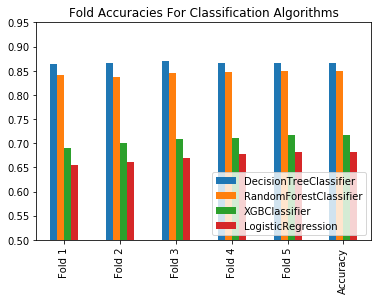

In [124]:
#Analyze fold accuracies and algorithm performances (overall and across folds)
plt.figure(figsize = (7,7))
score_df.plot(kind='bar', yticks=np.arange(0.5, 1, 0.05), ylim = 0.5,
                                  title = "Fold Accuracies For Classification Algorithms")
plt.legend(loc='lower right')
plt.show()

In [126]:
#Perform hyperparameter fine tuning on applicable algorithms
clf = LogisticRegression()

parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clf, param_grid=parameters, cv=5)
fitmodel.fit(X_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)

(LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), {'C': 10}, 0.66138436238600684)


In [128]:
#Rerun ML Pipeline with adjusted hyperparameters for applicable algorithm
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    LogisticRegression(C=10)
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier,LogisticRegression
Fold 1,0.864723,0.848281,0.689836,0.655456
Fold 2,0.868087,0.844544,0.701046,0.661435
Fold 3,0.871699,0.846288,0.708022,0.670404
Fold 4,0.868834,0.844357,0.710575,0.676196
Fold 5,0.869936,0.847214,0.717750,0.682617
Accuracy,0.869936,0.847214,0.717750,0.682617


In [130]:
#Construct final ML algorithm based on pipeline results
clf = DecisionTreeClassifier()
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print(score)

0.89539748954
